In [2]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from keras.models import Sequential
from keras.models import load_model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from keras.optimizers import Adam, SGD, Adagrad
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D
#import cv2
import keras
import os
#tf.logging.set_verbosity(tf.logging.ERROR)


Using TensorFlow backend.


In [3]:

default_image_size = tuple((64,64))
image_size = 0
directory_root = '/home/cudacenter/TE/Aishwarya_Harpale/folder3/'
width=64
height=64
depth=3

In [4]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            return cv2.resize(image, default_image_size)
            #return img_to_array(image)
        else:
            return np.array([])
        
    except Exception as e:
        print("Error : ".format(e))
        return None

In [5]:
import sys
print(sys.version_info)

sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)


In [6]:
image_list, label_list =[],[]
try:
    print("Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir:
        if directory == ".DS_Store" :
            root_dir.remove(directory)
            
    for plant_folder in root_dir :
        #print('gh')
#         plant_disease_folder_list = listdir(" %(root)s/%(sub)s/" %{'root':directory_root, 'sub':plant_folder})
        plant_disease_folder_list = listdir(directory_root+'/'+plant_folder)
        #print(plant_disease_folder_list)
        
        for disease_folder in plant_disease_folder_list:
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)
                
        for plant_disease_folder in plant_disease_folder_list:
            print("Processing %s ..." %plant_disease_folder)
            plant_disease_image_list = listdir(directory_root+"/"+plant_folder+"/"+plant_disease_folder+"/")
            #print('ghll')
            
            for single_plant_disease_image in plant_disease_image_list:
                if single_plant_disease_image == ".DS_store":
                    plant_disease_image_list.remove(single_plant_disease_image)
            
            for image in plant_disease_image_list:
                image_directory =directory_root+"/"+plant_folder+"/"+plant_disease_folder+"/"+image
                #print(image_directory)
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True :
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
                    
    print("--- Loading images completed ---")
    #print(label_list)
    
except Exception as e:
    print("Error : ".format(e))

Loading images ...
Processing Tomato___Bacterial_spot ...
Processing Tomato___healthy ...
Processing Tomato___Late_blight ...
Processing Tomato___Tomato_Yellow_Leaf_Curl_Virus ...
Processing Tomato___Spider_mites Two-spotted_spider_mite ...
Processing Tomato___Tomato_mosaic_virus ...
Processing Tomato___Leaf_Mold ...
Processing Tomato___Early_blight ...
Processing Tomato___Target_Spot ...
Processing Tomato___Septoria_leaf_spot ...
--- Loading images completed ---


In [7]:
image_size = len(image_list)

In [8]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
#pickle.dump(label_binarizer, open('label_transform.pk1','wb'))
n_classes = len(label_binarizer.classes_)

print(label_binarizer.classes_)
#print

['Tomato___Bacterial_spot' 'Tomato___Early_blight' 'Tomato___Late_blight'
 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' 'Tomato___Tomato_mosaic_virus'
 'Tomato___healthy']


In [9]:
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
with tf.Session() as sess:
    print (sess.run(c))

[[22. 28.]
 [49. 64.]]


In [10]:

# from PIL import Image
# for i in range(10):
#     image_list[i].shape
#     img = Image.fromarray(image_list[i], 'RGB')
#     img.save('my'+str(i)+'.png')

In [11]:
np_image_list = np.array(image_list, dtype=np.float16)/225.0 #255?

In [12]:
print("Splitting data")
x_train, x_test, y_train, y_test= train_test_split(np_image_list, image_labels, test_size =0.2, random_state=42)

Splitting data


In [13]:
print(len(x_train))
print(x_train.shape)
print(n_classes)

14527
(14527, 64, 64, 3)
10


In [14]:
aug = ImageDataGenerator(
    rotation_range=5, width_shift_range=0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    )

In [15]:
# aug = ImageDataGenerator(
#     rotation_range=0, width_shift_range=0,
#     height_shift_range = 0, shear_range=0,
#     zoom_range=0, horizontal_flip = True,
#     fill_mode='nearest')

In [16]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim= 1
    
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(BatchNormalization(axis=chanDim))
model.add(Activation("relu"))

model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(BatchNormalization(axis=chanDim))
model.add(Activation("relu"))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(BatchNormalization(axis=chanDim))
model.add(Activation("relu"))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(BatchNormalization(axis=chanDim))
model.add(Activation("relu"))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(BatchNormalization(axis=chanDim))
model.add(Activation("relu"))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.4))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.4))

model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 21, 21, 64)       

In [17]:
n_classes

10

In [18]:
# # base_model = VGG16(weights='imagenet', include_top=False)
# #base_model = Alex(weights='imagenet', include_top=False)
# base_model = InceptionV3(weights='imagenet', include_top=False, input_shape = (64,64,3) )
# #base_model = Xception(include_top=False, weights='imagenet')
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# # let's add a fully-connected layer
# x = Dense(75, activation='relu')(x)
# y = Dropout(0.3)(x)
# # and a logistic layer -- let's say we have 10 classes
# predictions = Dense(n_classes, activation='softmax')(y)

# model = Model(inputs=base_model.input, outputs=predictions)
# print(base_model.input)
# # for layser in model.layers:
# #    layer.trainable = True
# model.summary()

In [19]:
# incept = keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_tensor=None, input_shape=None, pooling=None)#, classes=1000)

In [34]:
EPOCHS = 30
INIT_LR = 0.001
BS = 32
#opt = SGD(lr=INIT_LR, decay=1e-6, momentum=0.9, nesterov=True)
#opt = Adagrad(lr=INIT_LR)
opt=Adam(lr=INIT_LR)#, decay=INIT_LR / EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

print("Training...")

Training...


In [21]:
#y_test

In [35]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
#    steps_per_epoch=len(x_train) /BS,
    steps_per_epoch=40,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/30
40/40 [==============================] - 14s 345ms/step - loss: 0.5253 - acc: 0.8266 - val_loss: 2.2763 - val_acc: 0.5531
Epoch 2/30
40/40 [==============================] - 5s 132ms/step - loss: 0.4957 - acc: 0.8352 - val_loss: 2.4362 - val_acc: 0.5834
Epoch 3/30
40/40 [==============================] - 5s 132ms/step - loss: 0.4460 - acc: 0.8516 - val_loss: 0.6972 - val_acc: 0.7927
Epoch 4/30
40/40 [==============================] - 5s 133ms/step - loss: 0.5034 - acc: 0.8350 - val_loss: 1.7930 - val_acc: 0.6401
Epoch 5/30
40/40 [==============================] - 5s 131ms/step - loss: 0.4676 - acc: 0.8305 - val_loss: 1.5496 - val_acc: 0.6090
Epoch 6/30
40/40 [==============================] - 5s 131ms/step - loss: 0.4739 - acc: 0.8258 - val_loss: 4.0627 - val_acc: 0.4518
Epoch 7/30
40/40 [==============================] - 5s 133ms/step - loss: 0.4729 - acc: 0.8391 - val_loss: 2.0439 - val_acc: 0.6096
Epoch 8/30
40/40 [==============================] - 5s 135ms/step - loss: 0

In [ ]:
# def step_decay(epoch):
#     initial_lrate=0.001
#     drop=0.1
#     epochs_drop=16.0
#     lrate=initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
#     return lrate

In [ ]:
# data_aug = False
# #model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001,decay = 1e-03),metrics=['accuracy'])

# if not data_aug:
#     print('Not using real-time data augmentation.')
#     history = model.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size=8,epochs=15,verbose=2,steps_per_epoch=None)
    

# else:
#     print('Using real-time data augmentation.')
#     lr=keras.callbacks.LearningRateScheduler(step_decay)#,verbose=1)
#    # This will do preprocessing and realtime data augmentation:
# #     tbCallback=keras.callbacks.TensorBoard(log_dir='./Logs/Tensorboard_Logs', histogram_freq=0, 
# #                                            batch_size=32, write_graph=False, write_grads=False, 
# #                                            write_images=False, embeddings_freq=0, embeddings_layer_names=None, 
# #                                            embeddings_metadata=None)
# #     checkpoint=keras.callbacks.ModelCheckpoint('./Logs/Checkpoint', monitor='val_loss', 
# #                                                verbose=0, save_best_only=False, 
# #                                                save_weights_only=False, 
# #                                                mode='auto',
# #                                                period=1)

#     datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
#         width_shift_range=0.5,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.5,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=True)  # randomly flip images


# #     Compute quantities required for feature-wise normalization
# #     (std, mean, and principal components if ZCA whitening is applied).
#     datagen.fit(x_train)

#     # Fit the model on the batches generated by datagen.flow().
#     history = model.fit_generator(datagen.flow(x_train, y_train,batch_size=16),steps_per_epoch=20,epochs=10, validation_data=(x_test,y_test),workers=4)



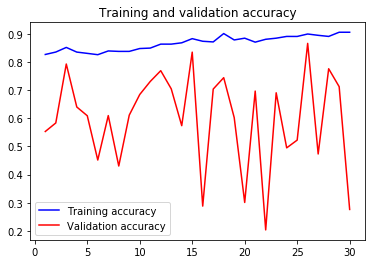

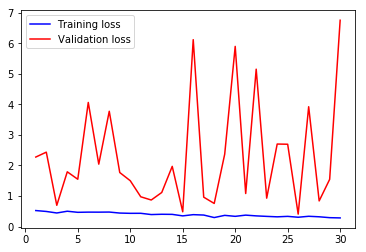

In [36]:
acc= history.history['acc']
val_acc=history.history['val_acc']
loss= history.history['loss']
val_loss=history.history['val_loss']
epochs = range(1, len(acc)+1)
plt.plot(epochs,acc,'b', label="Training accuracy")
plt.plot(epochs,val_acc,'r', label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs,loss,'b', label="Training loss")
plt.plot(epochs,val_loss,'r', label="Validation loss")
plt.legend()
plt.show()

In [37]:
print("Calculating model accuracy...")
scores_tr = model.evaluate(x_train, y_train)
scores_te = model.evaluate(x_test,y_test)
#print("Test Accuracy:".format( {scores[1]*100}))
print(scores_tr)
print(scores_te)

Calculating model accuracy...
3632/3632 [==============================] - 2s 441us/step
[6.674056484537262, 0.2695670131315193]
[6.753091522250407, 0.276431718061674]


In [51]:
#print("Saving model...")
#pickle.dump(model,open('cnn_model.pk1','wb'))

model.save('my_model.h5') 